# Generate image embeddings using a pre-trained CNN and store them in Hub
Author: Margaux Masson-Forsythe

## Imports

In [ ]:
!pip3 install hub==2.0.4 && torch==1.8.1
# restart runtime after installing
# using torch 1.8.1 because of an error 403 happening with the older version 

In [ ]:
import numpy as np
import hub
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
from torchsummary import summary
import torchvision.models as models
import glob
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print(hub.__version__)

2.0.4


In [ ]:
print(torch.__version__)

1.8.1+cu102


## Load Data: Dog breeds from https://www.kaggle.com/eward96/dog-breed-images

In [ ]:
!export KAGGLE_USERNAME="xxxx" && export KAGGLE_KEY="xxxxx" && mkdir -p data && cd data && kaggle datasets download -d eward96/dog-breed-images && unzip -n dog-breed-images.zip && rm dog-breed-images.zip

 90% 83.0M/91.7M [00:00<00:00, 205MB/s]
100% 91.7M/91.7M [00:00<00:00, 202MB/s]
Archive:  dog-breed-images.zip


In [ ]:
!ls data

bernese_mountain_dog  chihuahua  dachshund	   jack_russell  pug
border_collie	      corgi	 golden_retriever  labrador	 siberian_husky


In [ ]:
data_dir = 'data'

In [ ]:
list_imgs = glob.glob(data_dir + "/**/*.jpg")
print(f"There are {len(list_imgs)} images in the dataset {data_dir}")

There are 918 images in the dataset data


In [ ]:
# create dataloader with required transforms 
tc = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()              
    ])

image_datasets = datasets.ImageFolder(data_dir, transform=tc)
dloader = torch.utils.data.DataLoader(image_datasets, batch_size=10, shuffle=False)

torch.Size([256, 256, 3])
tensor([[[0.9608, 0.9608, 0.9608,  ..., 0.8275, 0.8353, 0.8039],
         [0.9608, 0.9608, 0.9608,  ..., 0.8471, 0.8392, 0.8118],
         [0.9608, 0.9608, 0.9569,  ..., 0.8471, 0.8392, 0.8118],
         ...,
         [0.6667, 0.6980, 0.6667,  ..., 0.7569, 0.7922, 0.7961],
         [0.7294, 0.7451, 0.7137,  ..., 0.7843, 0.7647, 0.7725],
         [0.7490, 0.7490, 0.7647,  ..., 0.8235, 0.8353, 0.8392]],

        [[0.9647, 0.9647, 0.9647,  ..., 0.8431, 0.8471, 0.8118],
         [0.9647, 0.9647, 0.9647,  ..., 0.8549, 0.8471, 0.8157],
         [0.9647, 0.9647, 0.9608,  ..., 0.8431, 0.8431, 0.8196],
         ...,
         [0.6784, 0.7137, 0.6824,  ..., 0.7569, 0.7882, 0.7922],
         [0.7373, 0.7647, 0.7333,  ..., 0.7804, 0.7608, 0.7686],
         [0.7608, 0.7686, 0.7882,  ..., 0.8235, 0.8314, 0.8353]],

        [[0.9804, 0.9804, 0.9804,  ..., 0.8275, 0.8314, 0.8000],
         [0.9804, 0.9804, 0.9804,  ..., 0.8627, 0.8510, 0.8196],
         [0.9804, 0.9804, 0.9765

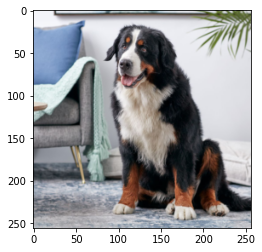

In [ ]:
for img, label in dloader:
  print(np.transpose(img[0], (1,2,0)).shape)
  print(img[0])
  plt.imshow((img[0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))
  plt.show()
  break

Pytorch default backend for images are Pillow, and when you use ToTensor()class, PyTorch automatically converts all images into [0,1] so no need to normalize the images here.


In [ ]:
len(image_datasets)

918

## Generate embeddings

In [ ]:
def copy_embeddings(m, i, o):
    """Copy embeddings from the penultimate layer.
    """
    o = o[:, :, 0, 0].detach().numpy().tolist()
    outputs.append(o)

In [ ]:
# fetch pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
# Select the desired layer
layer = model._modules.get('avgpool')
# attach hook to the penulimate layer
_ = layer.register_forward_hook(copy_embeddings)

In [ ]:
outputs = []  # list of embeddings

model.eval() # Inference mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Generate image's embeddings for all images in dloader and saves 
# them in the list outputs
for X, y in dloader:
    _ = model(X)

In [ ]:
len(outputs)

92

In [ ]:
# flatten list of embeddings to remove batches
list_embeddings = [item for sublist in outputs for item in sublist]
print(len(list_embeddings))

918


In [ ]:
assert len(list_embeddings) == len(image_datasets)

In [ ]:
np.array(list_embeddings[0]).shape

(512,)

## Send to Hub

In [ ]:
!activeloop login -u username -p password

Successfully logged in to Activeloop.


In [ ]:
hub_dogs_path = 'hub://margauxmforsythe/dogs_breeds_embeddings'

In [ ]:
with hub.empty(hub_dogs_path) as ds:
    # Create the tensors 
    ds.create_tensor('images', htype = 'image', sample_compression = 'jpeg')
    ds.create_tensor('embeddings')

    # Add arbitrary metadata - Optional
    ds.info.update(description = 'Dog breeds embeddings dataset')
    ds.images.info.update(camera_type = 'SLR')
    
    # Iterate through the images and their corresponding embeddings, and append them to hub dataset
    for i in tqdm(range(len(image_datasets))):
      img = image_datasets[i][0].detach().numpy().transpose(1, 2, 0)
      img = img * 255 # images are normalized
      img = img.astype(np.uint8)
      ds.images.append(img)  # Append to Hub Dataset
      ds.embeddings.append(list_embeddings[i]) # Append to Hub Dataset
                
# Long-term storage is updated at the end of the code block inside 'with'

Your Hub dataset has been successfully created!


100%|██████████| 918/918 [00:23<00:00, 38.91it/s]


Let's see the images in the dataset ds and their embeddings

Image:
(256, 256, 3)


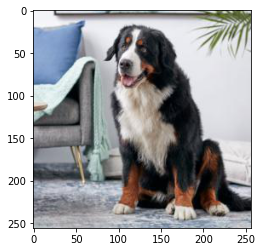

[0.3654722  1.6798172  1.32954156 0.08319058 0.75772887 1.74707603
 2.01733541 1.6304729  0.50725091 3.35410452]
Image:
(256, 256, 3)


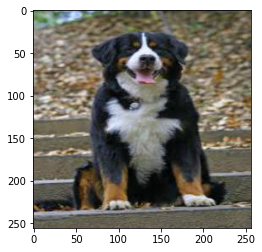

[0.81616133 1.4296037  1.47882152 0.14237563 0.93061727 0.9090566
 0.4618707  1.44441414 0.20901711 3.02357078]


In [ ]:
def show_image_in_ds(ds, idx=1):
    image = ds.images[idx].numpy()
    embedding = ds.embeddings[idx].numpy()
    print("Image:")
    print(image.shape)
    plt.imshow(image)
    plt.show()
    print(embedding[0:10]) # show only 10 first values of the image embedding

for i in range(2):
    show_image_in_ds(ds, i)

## Check the dataset was correctly sent to Hub

hub://margauxmforsythe/dogs_breeds_embeddings loaded successfully.


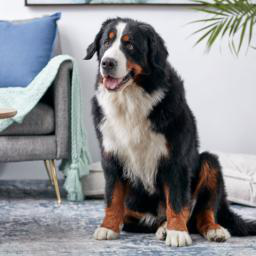

In [ ]:
ds_from_hub = hub.dataset(hub_dogs_path)
Image.fromarray(ds_from_hub.images[0].numpy())

Image:
(256, 256, 3)


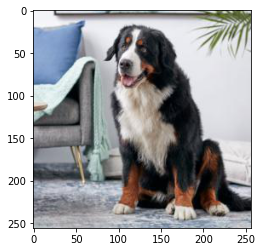

[0.3654722  1.6798172  1.32954156 0.08319058 0.75772887 1.74707603
 2.01733541 1.6304729  0.50725091 3.35410452]
Image:
(256, 256, 3)


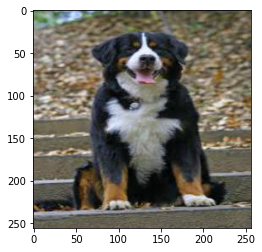

[0.81616133 1.4296037  1.47882152 0.14237563 0.93061727 0.9090566
 0.4618707  1.44441414 0.20901711 3.02357078]
Image:
(256, 256, 3)


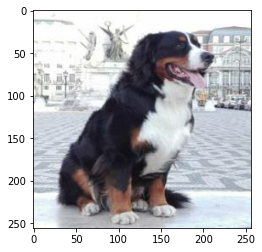

[0.13786289 2.39912081 0.96784693 0.1817003  0.87487513 1.32822526
 0.57953429 2.90846252 0.24717608 1.58063555]
Image:
(256, 256, 3)


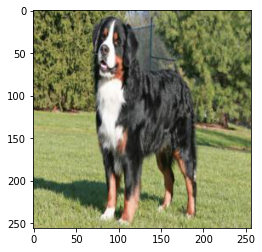

[0.7792896  2.43529058 0.42410848 0.25027147 1.48420453 0.9182964
 0.91754335 1.65854025 0.62109679 4.11812496]


In [ ]:
for i in range(4):
    show_image_in_ds(ds_from_hub, i)